# Validation – Rigid Translation (Sample3)

This notebook validates the **d2ic** pipeline on the DIC Challenge 1.0 *Sample3* dataset.
Each deformed frame is a rigid translation of the reference image (0.1 px per frame in both directions).

Goal: run a mesh-based DIC solve on one frame and compare the mean nodal displacement against the expected shift.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from __future__ import annotations

from pathlib import Path
import re
import sys

import logging
import os

# Silence noisy PJRT plugin init errors on environments without a working CUDA stack.
logging.getLogger('jax._src.xla_bridge').setLevel(logging.CRITICAL)

# Avoid CUDA init warnings on machines without a working GPU stack. on machines without a working GPU stack.
os.environ.setdefault('JAX_PLATFORMS', 'cpu')

import jax
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread

# Better numerical accuracy (can be disabled for speed on GPU).
jax.config.update("jax_enable_x64", True)


This notebook targets the new `d2ic` API (mask-to-mesh + `DICMeshBased` + solvers).
If you installed the package with `pip install -e .`, imports work directly.
Otherwise we add the local `D2IC/` folder to `sys.path`.


## 1) Load 2 images + ROI mask


repo_root: /workspaces/08_dic/D2IC
ref: Sample3 Reference.tif (512, 512) float64
def: Sample3-004 X0.40 Y0.40 N2 C0 R0.tif (512, 512) float64
mask: (512, 512) bool roi_pixels= 233766
expected shift [px]: (0.4, 0.4)


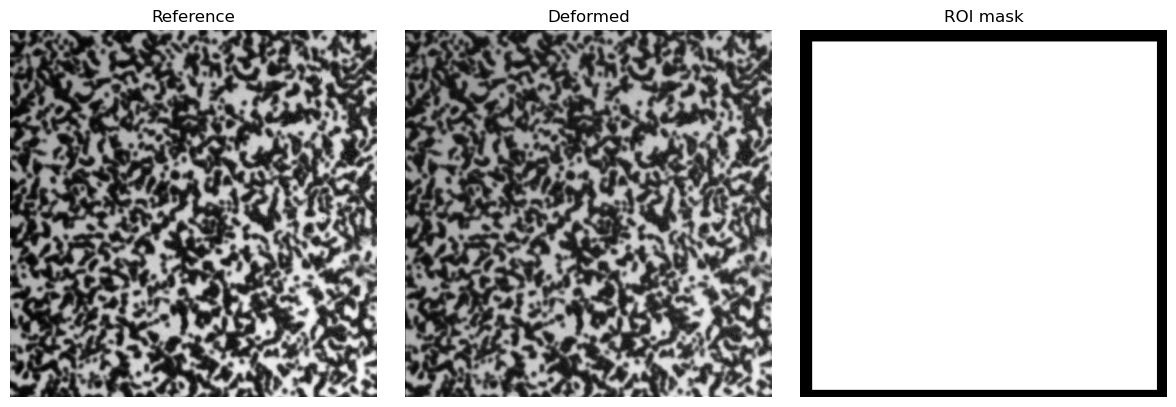

In [2]:
from d2ic import (
    InitMotionConfig,
    MeshDICConfig,
    DICInitMotion,
    DICMeshBased,
    TranslationZNCCSolver,
    GlobalCGSolver,
    mask_to_mesh_assets_gmsh,
    DICPlotter,
)
img_dir = Path('doc') / 'img' / 'Sample3'
out_dir = Path('doc') / '_outputs' / 'validation_notebook'
out_dir.mkdir(parents=True, exist_ok=True)

ref_path = img_dir / 'Sample3 Reference.tif'
def_path = img_dir / 'Sample3-004 X0.40 Y0.40 N2 C0 R0.tif'

im_ref = imread(ref_path).astype(float)
im_def = imread(def_path).astype(float)

mask = imread(img_dir / 'roi.tif')
if mask.ndim == 3:
    mask = mask[..., 0]
mask = mask > 0

match = re.search(r'X(?P<dx>-?\d+\.\d+)\s+Y(?P<dy>-?\d+\.\d+)', def_path.stem)
expected = (float(match.group('dx')), float(match.group('dy'))) if match else (float('nan'), float('nan'))

print('ref:', ref_path.name, im_ref.shape, im_ref.dtype)
print('def:', def_path.name, im_def.shape, im_def.dtype)
print('mask:', mask.shape, mask.dtype, 'roi_pixels=', int(mask.sum()))
print('expected shift [px]:', expected)

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(im_ref, cmap='gray')
ax[0].set_title('Reference')
ax[1].imshow(im_def, cmap='gray')
ax[1].set_title('Deformed')
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('ROI mask')
for a in ax:
    a.axis('off')
plt.tight_layout()


## 2) Build a mesh from the ROI mask (Gmsh)

We generate a quadrilateral mesh from `roi.tif` using the Gmsh-based pipeline `mask_to_mesh_assets_gmsh`.

Requirements:
- Python packages: `gmsh`, `meshio`
- System libraries for Gmsh (platform-dependent)


In [3]:
try:
    mesh, assets = mask_to_mesh_assets_gmsh(
        mask=mask,
        element_size_px=40.0,
        contour_step_px=2.0,
        remove_islands=True,
        min_island_area_px=64,
    )
except ImportError as exc:
    raise ImportError(
        'Gmsh meshing requires the `gmsh` and `meshio` Python packages. '
        'Install them (and any system deps for Gmsh), then rerun this cell.'
    ) from exc

print('nodes:', np.asarray(mesh.nodes_xy).shape)
print('elements:', np.asarray(mesh.elements).shape)



nodes: (1178, 2)
elements: (185, 4)


## 3) Configure the `d2ic` pipelines


In [4]:
init_cfg = InitMotionConfig(win=41, search=24)
mesh_cfg = MeshDICConfig(
    max_iters=400,
    tol=1e-3,
    reg_strength=1e-4,
    strain_gauge_length=40.0,
)

dic_mesh = DICMeshBased(
    mesh=mesh,
    solver=GlobalCGSolver(interpolation='cubic'),
    config=mesh_cfg,
)
dic_mesh.prepare(im_ref, assets)

dic_init = DICInitMotion(init_cfg, TranslationZNCCSolver(init_cfg))
dic_init.prepare(im_ref, assets)
init_res = dic_init.run(im_def)
dic_mesh.set_initial_guess(init_res.u_nodal)

u0 = np.asarray(init_res.u_nodal)
print('init guess mean [px]:', u0.mean(axis=0))


init guess mean [px]: [0.         0.01342238]


## 4) Solve global DIC (CG solver)


In [5]:
result = dic_mesh.run(im_def)
u = np.asarray(result.u_nodal)
print('u_nodal:', u.shape)
print('diagnostics:', result.diagnostics.info)


u_nodal: (1178, 2)
diagnostics: {'stage': 'mesh_based', 'note': 'placeholder', 'n_iters': 36, 'history': 'attached', 'strain': 'green_lagrange'}


## 5) Visualize the displacement field


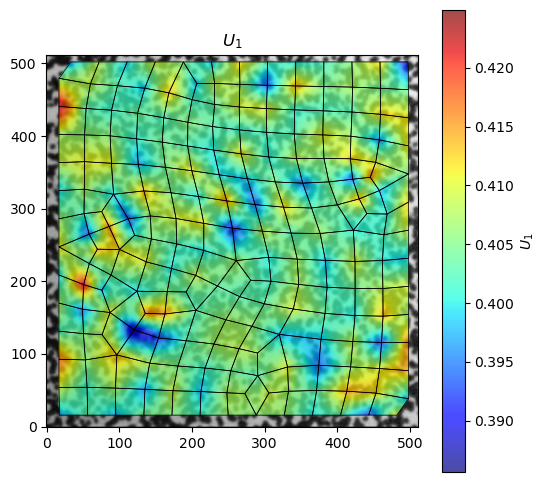

In [6]:
plotter = DICPlotter(
    result=result,
    mesh=mesh,
    def_image=im_def,
    ref_image=im_ref,
    project_on_deformed='fast',
)

fig, ax = plotter.plot('u1', image_alpha=0.7, plotmesh=True)
plt.show()

In [7]:
u_mean = u.mean(axis=0)
u_std = u.std(axis=0)
print(f'Mean displacement [px]: Ux={u_mean[0]:.4f} ± {u_std[0]:.4f}, Uy={u_mean[1]:.4f} ± {u_std[1]:.4f}')
if np.all(np.isfinite(expected)):
    err = u_mean - np.asarray(expected)
    print(f'Expected [px]: Ux={expected[0]:.4f}, Uy={expected[1]:.4f}')
    print(f'Error [px]:    dUx={err[0]:.4f}, dUy={err[1]:.4f}')


Mean displacement [px]: Ux=0.0725 ± 0.1553, Uy=0.0820 ± 0.1510
Expected [px]: Ux=0.4000, Uy=0.4000
Error [px]:    dUx=-0.3275, dUy=-0.3180


## 6) Notes

- The current init-motion stage is translation-only and serves as a coarse initial guess.
- The mesh-based solve runs on CPU or GPU depending on your JAX installation and device availability.
